In [9]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from scipy.stats.distributions import norm
import seaborn as sns
import matplotlib.pyplot as plt
from alive_progress import alive_bar
import pdb
from pydci.utils import fit_domain

# KL Divergence for Sequential Parameter Drift Detection

The purpose of this notebook is to visualize the KL divergence as a metric to measure the quantity of information gained in a data-consistent update.
In particular we may look at this metric to try and inform us when a shift in the parameter estiamtes has occured in a sequential parameter estimation problem.
As we have seen before, the KL divergence is defined as:

$$
(\pi_{\Lambda}^\mathrm{up}||\pi_{\Lambda}^\mathrm{init}) = \int_{\Lambda} \pi_{\Lambda}^\mathrm{up}(\lambda) \log \frac{\pi_{\Lambda}^\mathrm{up}(\lambda)}{\pi_{\Lambda}^\mathrm{init}(\lambda)} d\lambda
$$

for continuous distributions $\pi_{\Lambda}^\mathrm{init}$ and $\pi_{\Lambda}^\mathrm{up}$.

For the data-consistent update, it can be shown that:

$$
\mathrm{KL}\left(\pi_{\Lambda}^{\mathrm{up}} \| \pi_{\Lambda}^{\mathrm{init}}\right)=\int_{\Lambda} r(Q(\lambda)) \log (r(Q(\lambda))) d \mathbb{P}_{\Lambda}^{\mathrm{init}}=\int_{\mathcal{D}} \pi_{\mathcal{D}}^{\mathrm{obs}}(q) \log \left(\frac{\pi_{\mathcal{D}}^{\mathrm{obs}}(q)}{\pi_{\mathcal{D}}^\mathrm{pred}(q)}\right) d \mu_{\mathcal{D}} = \mathrm{KL}\left(\pi_{\mathcal{D}}^{\mathrm{obs}} \| \pi_{\mathcal{D}}^{\mathrm{pred}}\right)
$$

The observed and predicted distributions are over our observable space $\mathcal{D}$.

Note in the sequential update scenario we have $\pi^\mathrm{init} = \pi_{i-1}^\mathrm{up}$, where we drop the $\Lambda$ subscript, making it clear that the initial and updated distributions are over the same parameter space $\Lambda$.
Thus we expect the information gain from a sequentail update to be equal to the KL Divergence between the observed and predicted distributions on any given iteration.
Furthermore, we note that in sequential DCI parmaeter estimation using a data-construted map such as the $Q_{PCA}$ map, the observed distribution is the same for each iteration, and should stay at a stationary $\mathcal{N}(0, 1)$ distribution.

## KL Divergence as mean of $\pi^\mathrm{pred}$ shifts

Lets see how the KL divergene changes as we shift the $N(0,1)$ distribution by $\pm a*\sigma$, for $ a \in [0, 1, 2, 3] $.

<AxesSubplot: xlabel='x', ylabel='Density'>

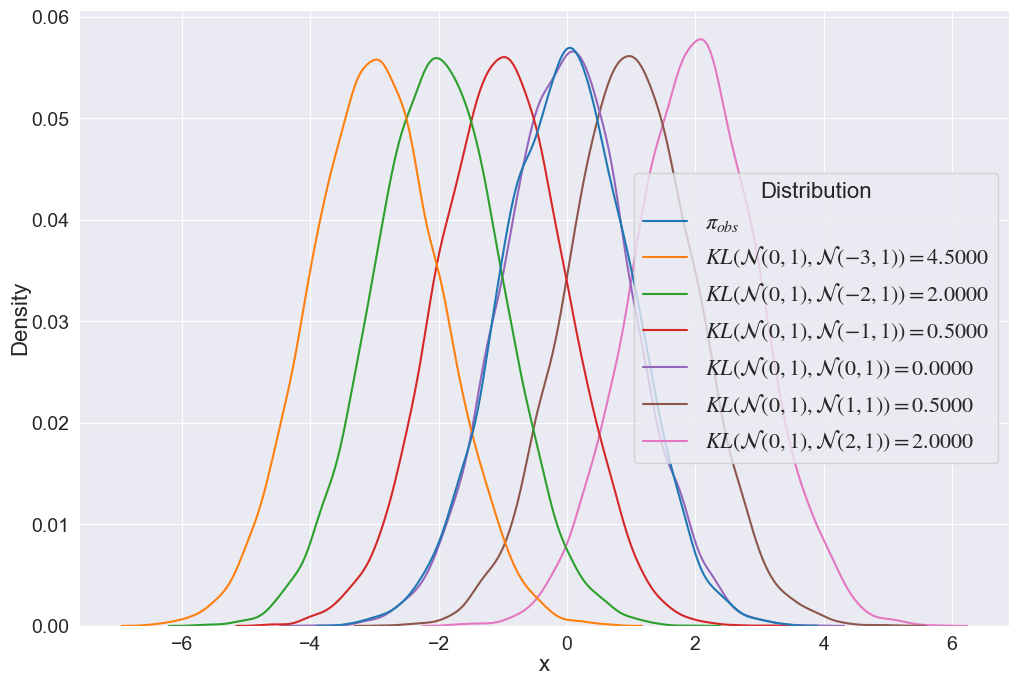

In [14]:
num_samples = 10000
pi_obs = norm(0, 1)
pi_obs_x = pd.DataFrame({"x": pi_obs.rvs(size=(num_samples))})
pi_obs_x["Distribution"] = "$\pi_{{obs}}$"
pi_obs_x["KL"] = 0.0

mean_range = np.arange(-3, 3, 1)
pi_dists = [pi_obs_x]
for i, m in enumerate(mean_range):
    pi_pred_i = norm(m, 1)
    num_samples = 10000
    pi_pred_i_x = pd.DataFrame({"x": pi_pred_i.rvs(size=(num_samples))})

    domain = fit_domain(pi_pred_i_x["x"].values.reshape(-1, 1), pad_ratio=2)
    x = np.linspace(domain[0][0], domain[0][1], 10000)
    kl = entropy(pi_obs.pdf(x), pi_pred_i.pdf(x))
    pi_pred_i_x[
        "Distribution"
    ] = f"$KL(\mathcal{{N}}(0, 1), \mathcal{{N}}({m}, 1)) = {kl:0.4f}$"
    pi_dists.append(pi_pred_i_x.copy())

pi = pd.concat(pi_dists)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.kdeplot(pi, hue="Distribution", x="x", ax=ax)

We see that as the predicted distribution shifts outside of the range of the observe distribution, the KL divergence increases.
In particular, once the normal distribution's mean has shifted 3 std-deviations, we see a KL divergence of 4.5, and minimal overlap between the two distributions.
This would correspond to a situtation where the predictabiltiy assumption may no longer hold, most likely due to a shift in parameter values from our sequential update.

## KL Divergence std_dev as of $\pi^\mathrm{pred}$ changes

Lets see how the KL divergene changes as we shrink the $N(0,1)$ distribution by $\pm a*\sigma$, for $ a \in [0, 1, 2, 3] $.

<AxesSubplot: xlabel='x', ylabel='Density'>

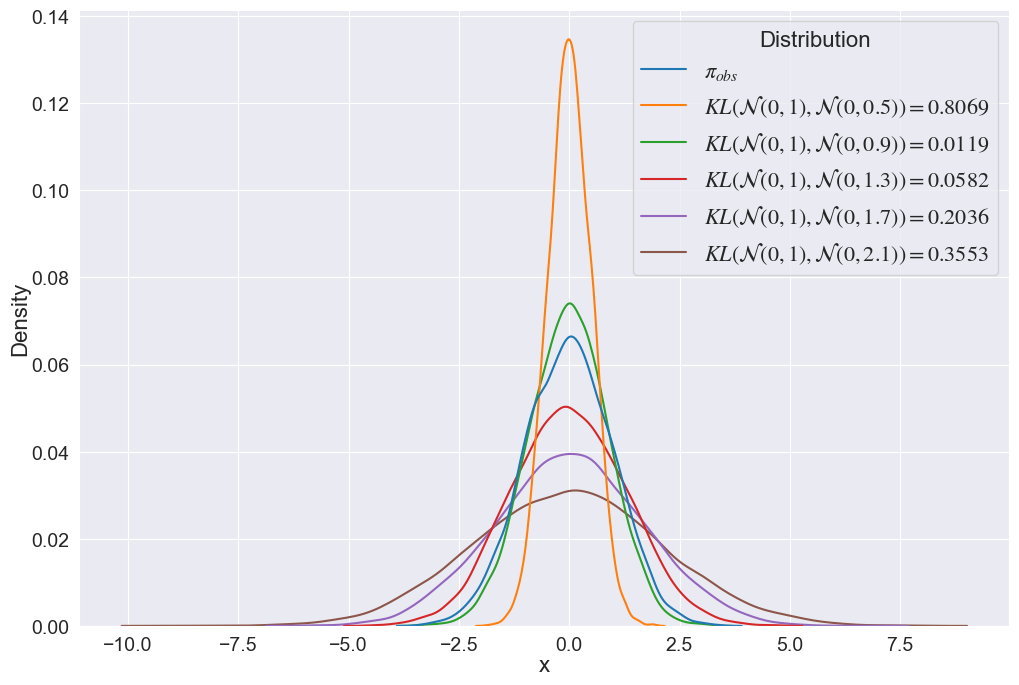

In [21]:
std_dev_range = np.arange(0.5, 2.5, 0.4)
pi_dists = [pi_obs_x]
for i, s in enumerate(std_dev_range):
    pi_pred_i = norm(0, s)
    num_samples = 10000
    pi_pred_i_x = pd.DataFrame({"x": pi_pred_i.rvs(size=(num_samples))})

    domain = fit_domain(pi_pred_i_x["x"].values.reshape(-1, 1), pad_ratio=2)
    x = np.linspace(domain[0][0], domain[0][1], 100000)
    kl = entropy(pi_obs.pdf(x), pi_pred_i.pdf(x))
    pi_pred_i_x[
        "Distribution"
    ] = f"$KL(\mathcal{{N}}(0, 1), \mathcal{{N}}(0, {s:0.1f})) = {kl:0.4f}$"
    pi_dists.append(pi_pred_i_x.copy())

pi = pd.concat(pi_dists)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.kdeplot(pi, hue="Distribution", x="x", ax=ax)

We see here that the change in the std-deviation of doesn't have as meaningful as an influence in the KL difference between the distributions, as the mean does of course.

## 2-Dimensional Plots

We can visualize on a grid how this KL divergence changes as we vary both the mean and and standard deviation.

In [103]:
def kl_scatter_plot(mean_values, sted_dev_values, size_mult=100):
    """
    Creates a scatter plot of the KL divergence between a standard normal
    and a normal distribution with mean and standard deviation given by
    the range of passed in values. Size of the points is proportional to
    the KL divergence times `size_mult`.

    Parameters
    ----------
    mean_values : array-like
        The mean values to use for the normal distributions.
    sted_dev_values : array-like
        The standard deviation values to use for the normal distributions.
    size_mult : float, optional
        The multiplier for the size of the points in the scatter plot.

    Returns
    -------
    ax : matplotlib.axes.Axes
        The axes containing the scatter plot.
    """

    # Create a 2D grid of x and y values using numpy.meshgrid()
    xx, yy = np.meshgrid(mean_values, std_dev_values)

    # Define the function to be plotted
    zz = np.zeros(xx.shape).ravel()
    x = np.linspace(mean_min, mean_max, 1000)
    m_s = [(i, j) for i in mean_values for j in std_dev_values]
    with alive_bar(len(m_s), title="Calculating KL divergences", force_tty=True) as bar:
        for i, (mean, std) in enumerate(m_s):
            pi_pred_i = norm(mean, std)
            zz[i] = entropy(pi_obs.pdf(x), pi_pred_i.pdf(x))
            bar()
        zz = zz.reshape(xx.shape)

    # Create a plot of the 2D grid
    plt.scatter(xx, yy, size_mult*zz, c=zz, cmap="viridis")

    # Add labels and a title to the plot
    plt.xlabel("$\mu$")
    plt.ylabel("$\sigma$")
    plt.title(f"$KL(\mathcal{{N}}(0, 1), \mathcal{{N}}(\mu, \sigma))$")

    plt.colorbar()
    plt.show()

Calculating KL divergences |████████████████████████████████████████| 80/80 [100


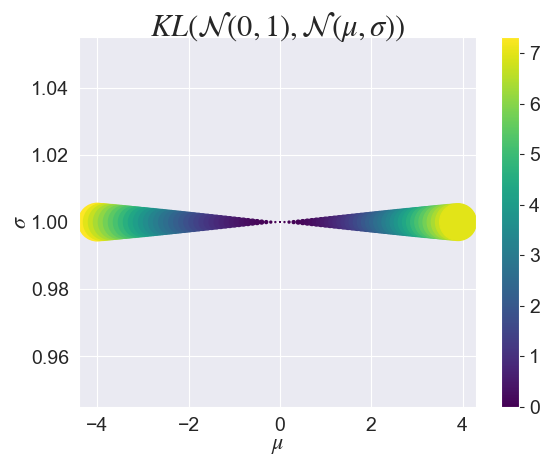

In [104]:
# Define the range and step size for x values -> Mean
mean_min, mean_max = -4, 4
step_size = 0.1
mean_values = np.arange(mean_min, mean_max, step_size)

# Define the range and step size for y values -> std dev
step_size = 0.1
std_dev_min, std_dev_max = 0.9, 1.1
std_dev_values = np.array([1.0])
# std_dev_values = np.arange(std_dev_min, std_dev_max, step_size)

ax = kl_scatter_plot(mean_values, std_dev_values)

Calculating KL divergences |████████████████████████████████████████| 240/240 [1


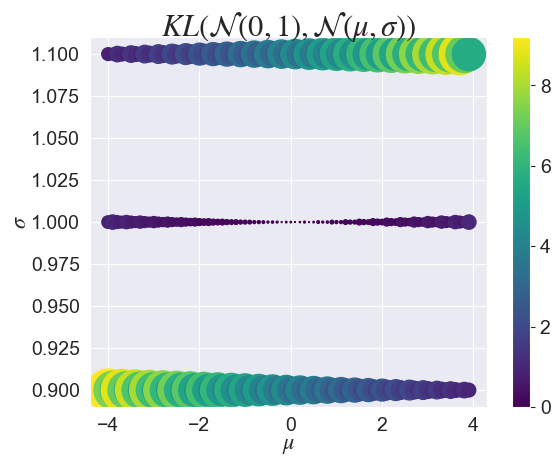

In [105]:
# Define the range and step size for x values -> Mean
mean_min, mean_max = -4, 4
step_size = 0.1
mean_values = np.arange(mean_min, mean_max, step_size)

# Define the range and step size for y values -> std dev
step_size = 0.1
std_dev_min, std_dev_max = 0.9, 1.1
std_dev_values = np.arange(std_dev_min, std_dev_max, step_size)

ax = kl_scatter_plot(mean_values, std_dev_values)

Calculating KL divergences |████████████████████████████████████████| 140/140 [1


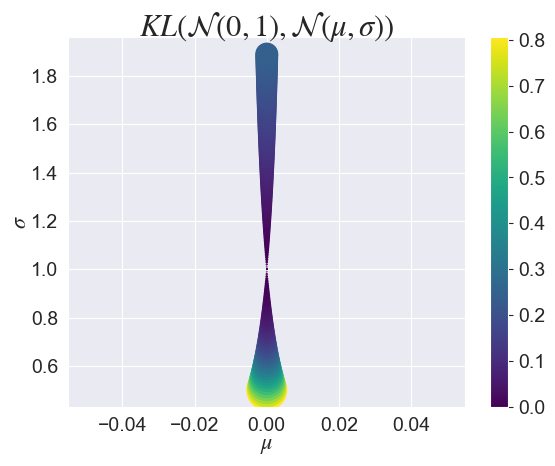

In [113]:
# Define the range and step size for x values -> Mean
# mean_min, mean_max = -4, 4
# step_size = 0.1
# mean_values = np.arange(mean_min, mean_max, step_size)
mean_values = np.array([0])

# Define the range and step size for y values -> std dev
step_size = 0.01
std_dev_min, std_dev_max = 0.5, 1.9
std_dev_values = np.arange(std_dev_min, std_dev_max, step_size)

ax = kl_scatter_plot(mean_values, std_dev_values, size_mult=1000)

Calculating KL divergences |████████████████████████████████████████| 420/420 [1


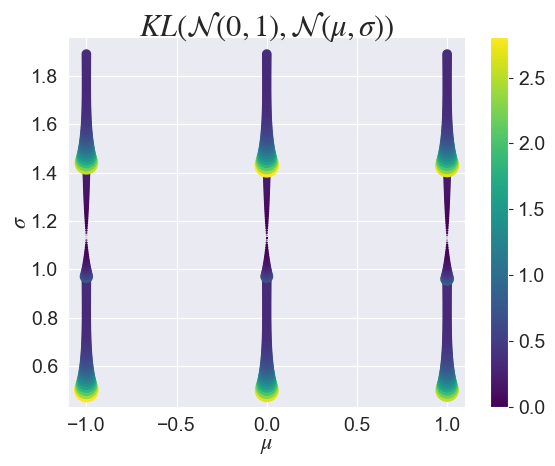

In [114]:
# Define the range and step size for x values -> Mean
mean_values = np.array([-1, 0, 1])

# Define the range and step size for y values -> std dev
step_size = 0.01
std_dev_min, std_dev_max = 0.5, 1.9
std_dev_values = np.arange(std_dev_min, std_dev_max, step_size)

kl_scatter_plot(mean_values, std_dev_values, size_mult=100)